1: Imports and Path Setup

In [1]:
import sys
from pathlib import Path
import os
import importlib
import zipfile
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# Add project root to Python path
notebook_dir = Path.cwd()
if notebook_dir.name == 'notebooks':
    project_root = notebook_dir.parent
else:
    project_root = notebook_dir

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import local modules
from src import extract, dataset, model

# Reloads modules (useful for development)
importlib.reload(extract) 
importlib.reload(dataset)
# Note: We will define the V-Net model inline below, but we reload src.model for utility functions
importlib.reload(model) 
from src.model import print_metrics, evaluate_model, dice_coeff, DiceCELoss

2: Data Extraction

In [2]:
# defaults to extracting from /workspaces/data
df = extract.extract_tsv_files()

# extract data from the zip files downloaded
# Update these paths to match your local environment if they changed
zip_path = "/Users/mostafazamaniturk/Documents/USD/AAI-521/AAI-521-finalproject/aai-521-final-project/data/"
interim_dir = Path("/Users/mostafazamaniturk/Documents/USD/AAI-521/AAI-521-finalproject/aai-521-final-project/interim/")

extract.extract_data(zip_path, interim_dir)

# Extract all .dcm files from their nested zips
root_dir = str(interim_dir / "imaging_files/case_image")

for dirpath, dirnames, filenames in os.walk(root_dir):
    for file in filenames:
        if file.endswith(".zip"):
            z_path = os.path.join(dirpath, file)
            extract_to = dirpath
            with zipfile.ZipFile(z_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
            print(f"Extracted {z_path} to {extract_to}")

Combined DataFrame shape: (25389, 79)
Files in /Users/mostafazamaniturk/Documents/USD/AAI-521/AAI-521-finalproject/aai-521-final-project/data/segmentation.zip extracted.
Files in /Users/mostafazamaniturk/Documents/USD/AAI-521/AAI-521-finalproject/aai-521-final-project/data/imaging_files.zip extracted.
Files in /Users/mostafazamaniturk/Documents/USD/AAI-521/AAI-521-finalproject/aai-521-final-project/data/annotation.zip extracted.
Extracted /Users/mostafazamaniturk/Documents/USD/AAI-521/AAI-521-finalproject/aai-521-final-project/interim/imaging_files/case_image/593973-000532/1.2.826.0.1.3680043.10.474.593973.9872/1.2.826.0.1.3680043.10.474.593973.9873.zip to /Users/mostafazamaniturk/Documents/USD/AAI-521/AAI-521-finalproject/aai-521-final-project/interim/imaging_files/case_image/593973-000532/1.2.826.0.1.3680043.10.474.593973.9872
Extracted /Users/mostafazamaniturk/Documents/USD/AAI-521/AAI-521-finalproject/aai-521-final-project/interim/imaging_files/case_image/593973-000700/1.2.826.0.1.

3: Data Mapping (DICOM & Masks)

In [3]:
# Matching Study Ids
dicom_root = str(interim_dir / "imaging_files/case_image")
mask_root = str(interim_dir / "segmentation")

# Map study_id -> DICOM folder
dicom_map = {}
for folder in glob.glob(os.path.join(dicom_root, "*")):
    study_id = os.path.basename(folder)
    # pick the deepest folder containing DICOMs
    dcm_subfolders = [f for f in glob.glob(os.path.join(folder, "**"), recursive=True) 
                      if os.path.isdir(f) and len(glob.glob(os.path.join(f, "*.dcm"))) > 0]
    if dcm_subfolders:
        dicom_map[study_id] = dcm_subfolders[0]
        
# Map study_id -> mask file
mask_map = {}
for mask_file in glob.glob(os.path.join(mask_root, "*_SEG.nii.gz")):
    study_id = os.path.basename(mask_file).split("_")[0]
    mask_map[study_id] = mask_file

# Only keep the studies that have both DICOMs and masks
dataset_entries = [(dicom_map[s], mask_map[s]) for s in dicom_map if s in mask_map]

print(f"Found {len(dataset_entries)} paired DICOMs and masks")

Found 1231 paired DICOMs and masks


4: Train/Val/Test Split

In [42]:
# First split: train + temp (val+test)
train_entries, temp_entries = train_test_split(
    dataset_entries, test_size=0.3, random_state=42
)

# Second split: val + test
val_entries, test_entries = train_test_split(
    temp_entries, test_size=0.5, random_state=42
)

print(f"Dataset samples: {len(dataset_entries)}")
print(f"Train samples: {len(train_entries)}")
print(f"Val samples:   {len(val_entries)}")
print(f"Test samples:  {len(test_entries)}")

Dataset samples: 1231
Train samples: 861
Val samples:   185
Test samples:  185


5: Dataset & DataLoader


In [5]:
target_shape = (1, 224, 224, 48) 
target_spacing = (1.0, 1.0, 1.0)

# Creating dataset objects
train_dataset = dataset.SpineSegDataset(train_entries, target_shape=target_shape, target_spacing=target_spacing)
val_dataset   = dataset.SpineSegDataset(val_entries, target_shape=target_shape, target_spacing=target_spacing)
test_dataset  = dataset.SpineSegDataset(test_entries, target_shape=target_shape, target_spacing=target_spacing)

# DataLoaders
# Reduced batch size to 1 to be safe with V-Net memory usage
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False)

6: Visualization Check

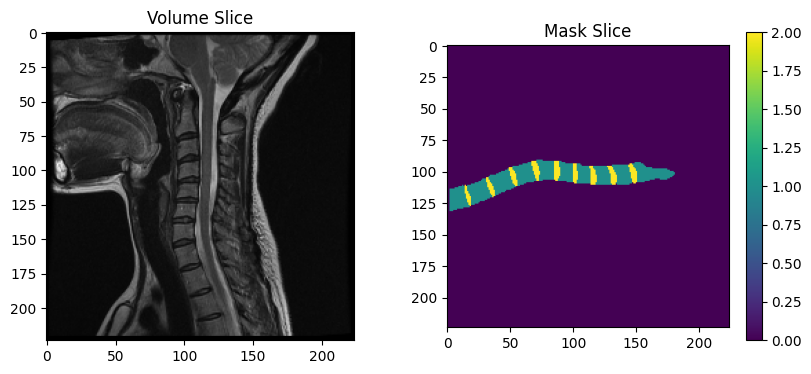

Volume shape: torch.Size([1, 1, 224, 224, 48])
Mask shape: torch.Size([1, 224, 224, 48])


In [51]:
vol, msk = next(iter(train_loader))
mid = msk.shape[-1] // 2 

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Volume Slice")
plt.imshow(vol[0,0,:,:,mid].cpu(), cmap="gray")

plt.subplot(1,2,2)
plt.title("Mask Slice")
plt.imshow(msk[0,:,:,mid].cpu(), cmap="viridis")
plt.colorbar()
plt.show()

print(f"Volume shape: {vol.shape}")
print(f"Mask shape: {msk.shape}")

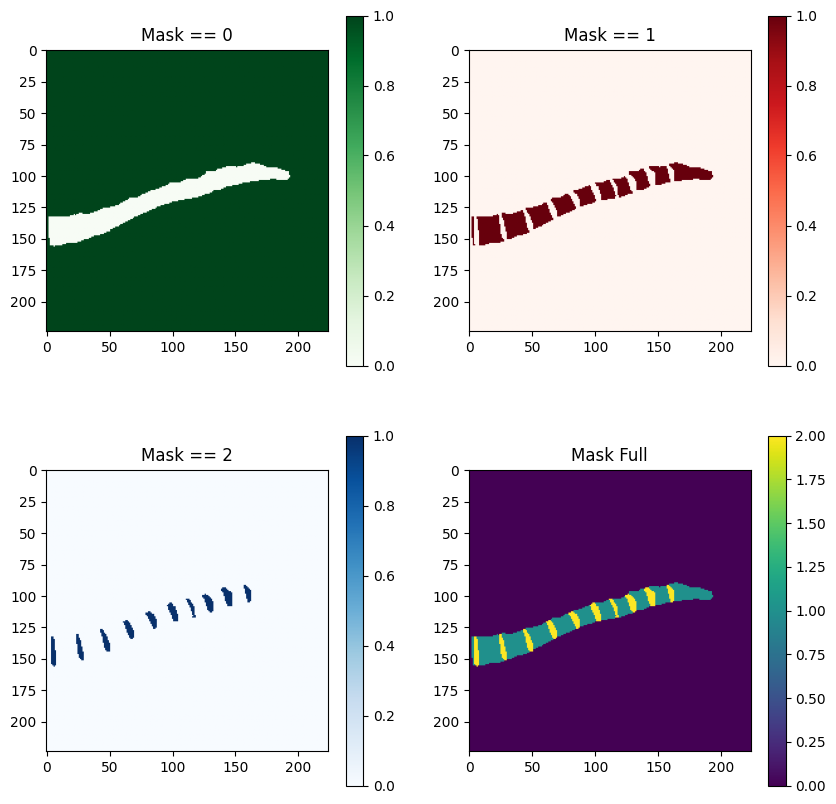

In [47]:
vol, msk = next(iter(train_loader))

# msk shape: (1, H, W, D)
mid = msk.shape[-1] // 2   # mid slice along depth

plt.figure(figsize=(10,10))

# Class 0
plt.subplot(2,2,1)
plt.title("Mask == 0")
plt.imshow((msk[0,:,:,mid] == 0).cpu(), cmap="Greens")
plt.colorbar()

# Class 1
plt.subplot(2,2,2)
plt.title("Mask == 1")
plt.imshow((msk[0,:,: ,mid] == 1).cpu(), cmap="Reds")
plt.colorbar()

# Class 2
plt.subplot(2,2,3)
plt.title("Mask == 2")
plt.imshow((msk[0,:,: ,mid] == 2).cpu(), cmap="Blues")
plt.colorbar()

# All labels
plt.subplot(2,2,4)
plt.title("Mask Full")
plt.imshow(msk[0,:,:,mid].cpu(), cmap="viridis")
plt.colorbar()

plt.show()

6.5: Metrics and Evaluation Utilities

In [23]:
# ==========================================
# Metrics & Helper Functions
# ==========================================

def dice_coeff(pred, target, num_classes=3, smooth=1e-5):
    """
    Compute per-class Dice coefficient
    pred: (B,H,W,D)
    target: (B,H,W,D)
    """
    dice = 0
    # One-hot encoding
    pred_one_hot = F.one_hot(pred, num_classes).permute(0, 4, 1, 2, 3)
    target_one_hot = F.one_hot(target, num_classes).permute(0, 4, 1, 2, 3)
    
    for c in range(num_classes):
        inter = torch.sum(pred_one_hot[:, c] * target_one_hot[:, c])
        union = torch.sum(pred_one_hot[:, c]) + torch.sum(target_one_hot[:, c])
        dice += (2 * inter + smooth) / (union + smooth)
    return dice / num_classes

def compute_segmentation_metrics(preds, masks, num_classes=3):
    """
    Compute Accuracy, Precision, Recall, F1 per class.
    """
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    for cls in range(num_classes):
        pred_cls = (preds == cls)
        mask_cls = (masks == cls)

        TP = (pred_cls & mask_cls).sum().item()
        FP = (pred_cls & (~mask_cls)).sum().item()
        FN = ((~pred_cls) & mask_cls).sum().item()
        TN = ((~pred_cls) & (~mask_cls)).sum().item()

        acc = (TP + TN) / (TP + TN + FP + FN + 1e-6)
        prec = TP / (TP + FP + 1e-6)
        rec = TP / (TP + FN + 1e-6)
        f1 = 2 * prec * rec / (prec + rec + 1e-6)

        metrics['accuracy'].append(acc)
        metrics['precision'].append(prec)
        metrics['recall'].append(rec)
        metrics['f1'].append(f1)

    return metrics

def evaluate_model(model, dataloader, device, num_classes=3):
    model.eval()
    all_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    all_dice = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            # Remove channel dim if present in mask: (B, 1, H, W, D) -> (B, H, W, D)
            if masks.ndim == 5:
                masks = masks.squeeze(1)
            masks = masks.to(device)

            # Handle V-Net Deep Sup output (it returns a list in train, tensor in eval)
            # We assume model is in eval() mode, so it returns a tensor
            outputs = model(images) 
            
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Dice
            batch_dice = []
            for cls in range(num_classes):
                pred_cls = (preds == cls).float()
                mask_cls = (masks == cls).float()
                intersection = (pred_cls * mask_cls).sum()
                union = pred_cls.sum() + mask_cls.sum()
                dice = (2 * intersection + 1e-6) / (union + 1e-6)
                batch_dice.append(dice.item())
            all_dice.append(batch_dice)
            
            # Other metrics
            metrics = compute_segmentation_metrics(preds, masks, num_classes)
            for key in all_metrics:
                all_metrics[key].append(metrics[key])
    
    # Average
    for key in all_metrics:
        # stack list of lists -> tensor -> mean
        all_metrics[key] = torch.tensor(all_metrics[key], dtype=torch.float32).mean(dim=0)

    all_dice = torch.tensor(all_dice)
    mean_dice = all_dice.mean().item()
    class_dice = all_dice.mean(dim=0).tolist()

    return mean_dice, class_dice, all_metrics

def print_metrics(metrics, class_names=None):
    import pandas as pd
    num_classes = len(metrics["accuracy"])
    if class_names is None:
        class_names = [f"Class {i}" for i in range(num_classes)]

    df = pd.DataFrame({
        "Class": class_names,
        "Accuracy": metrics["accuracy"].tolist(),
        "Precision": metrics["precision"].tolist(),
        "Recall": metrics["recall"].tolist(),
        "F1 Score": metrics["f1"].tolist()
    })

    print("\n===== Evaluation Metrics per Class =====\n")
    print(df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    print("\n========================================\n")

7: Define V-Net Architecture (Inline)

In [9]:
# ==========================================
# V-Net Model Definition (Light Version)
# ==========================================

class VNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers=1, kernel_size=3, padding=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(num_layers):
            input_ch = in_channels if i == 0 else out_channels
            self.layers.append(nn.Sequential(
                nn.Conv3d(input_ch, out_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm3d(out_channels),
                nn.PReLU()
            ))

        if in_channels != out_channels:
            self.project_residual = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        else:
            self.project_residual = None

    def forward(self, x):
        residual = x
        out = x
        for layer in self.layers:
            out = layer(out)
        if self.project_residual is not None:
            residual = self.project_residual(residual)
        return out + residual

class VNetDeepSup(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, base_filters=16):
        super().__init__()
        
        # --- Encoder ---
        self.in_conv = nn.Conv3d(in_channels, base_filters, kernel_size=3, padding=1)
        self.block1 = VNetBlock(base_filters, base_filters, num_layers=1)
        self.down1 = nn.Conv3d(base_filters, base_filters*2, kernel_size=2, stride=2)
        
        self.block2 = VNetBlock(base_filters*2, base_filters*2, num_layers=2)
        self.down2 = nn.Conv3d(base_filters*2, base_filters*4, kernel_size=2, stride=2)
        
        self.block3 = VNetBlock(base_filters*4, base_filters*4, num_layers=3)
        self.down3 = nn.Conv3d(base_filters*4, base_filters*8, kernel_size=2, stride=2)
        
        # --- Bottleneck ---
        self.block4 = VNetBlock(base_filters*8, base_filters*8, num_layers=3)
        self.up4 = nn.ConvTranspose3d(base_filters*8, base_filters*4, kernel_size=2, stride=2)

        # --- Decoder ---
        self.block3_dec = VNetBlock(base_filters*8, base_filters*8, num_layers=3)
        self.up3 = nn.ConvTranspose3d(base_filters*8, base_filters*2, kernel_size=2, stride=2)
        
        self.block2_dec = VNetBlock(base_filters*4, base_filters*4, num_layers=2)
        self.up2 = nn.ConvTranspose3d(base_filters*4, base_filters, kernel_size=2, stride=2)
        
        self.block1_dec = VNetBlock(base_filters*2, base_filters*2, num_layers=1)
        
        # --- Output Heads ---
        self.final_conv = nn.Conv3d(base_filters*2, out_channels, kernel_size=1)
        
        # Deep Supervision Heads
        self.ds3_conv = nn.Conv3d(base_filters*8, out_channels, kernel_size=1)
        self.ds2_conv = nn.Conv3d(base_filters*4, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        x1 = self.in_conv(x)
        x1 = self.block1(x1)
        x2 = self.down1(x1)
        x2 = self.block2(x2)
        x3 = self.down2(x2)
        x3 = self.block3(x3)
        
        # Bottleneck
        x4 = self.down3(x3)
        x4 = self.block4(x4)
        
        # Decoder Level 3
        up4 = self.up4(x4)
        if up4.shape != x3.shape: up4 = self._pad_to_match(up4, x3)
        cat4 = torch.cat([x3, up4], dim=1)
        dec3 = self.block3_dec(cat4)
        
        # Decoder Level 2
        up3 = self.up3(dec3)
        if up3.shape != x2.shape: up3 = self._pad_to_match(up3, x2)
        cat3 = torch.cat([x2, up3], dim=1)
        dec2 = self.block2_dec(cat3)
        
        # Decoder Level 1
        up2 = self.up2(dec2)
        if up2.shape != x1.shape: up2 = self._pad_to_match(up2, x1)
        cat2 = torch.cat([x1, up2], dim=1)
        dec1 = self.block1_dec(cat2)
        
        final_out = self.final_conv(dec1)

        # Return list if training, single tensor if validation
        if self.training:
            return [final_out, self.ds2_conv(dec2), self.ds3_conv(dec3)]
        else:
            return final_out

    def _pad_to_match(self, src, target):
        diffZ = target.shape[2] - src.shape[2]
        diffY = target.shape[3] - src.shape[3]
        diffX = target.shape[4] - src.shape[4]
        return F.pad(src, [diffX // 2, diffX - diffX // 2,
                           diffY // 2, diffY - diffY // 2,
                           diffZ // 2, diffZ - diffZ // 2])

8: Define Deep Supervision Loss and Training Loop

In [10]:
# ==========================================
# Deep Supervision Loss
# ==========================================
class DeepSupDiceCELoss(nn.Module):
    def __init__(self, weights=[1.0, 0.5, 0.25]):
        super().__init__()
        self.weights = weights
        self.base_loss = DiceCELoss() 

    def forward(self, outputs, targets):
        if not isinstance(outputs, list):
            return self.base_loss(outputs, targets)

        total_loss = 0
        target_shape = targets.shape[-3:]
        
        for i, pred in enumerate(outputs):
            if pred.shape[-3:] != target_shape:
                pred = F.interpolate(pred, size=target_shape, mode='trilinear', align_corners=False)
            
            layer_loss = self.base_loss(pred, targets)
            w = self.weights[i] if i < len(self.weights) else 0.0
            total_loss += w * layer_loss

        return total_loss

# ==========================================
# Specialized Training Loop
# ==========================================
def train_vnet_deep_sup(model, train_loader, val_loader, device, num_epochs=10, lr=1e-3, num_classes=3):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = DeepSupDiceCELoss(weights=[1.0, 0.5, 0.25])
    val_criterion = DiceCELoss() 
    
    history = {"train_loss": [], "val_loss": [], "val_dice": []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs_list = model(images) # Returns list of [High, Med, Low] res
            loss = criterion(outputs_list, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        history["train_loss"].append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        all_dice = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                output = model(images) # Returns single tensor in eval()
                loss = val_criterion(output, masks)
                val_loss += loss.item()

                probs = torch.softmax(output, dim=1)
                preds = torch.argmax(probs, dim=1)
                
                d = dice_coeff(preds, masks, num_classes=num_classes)
                all_dice.append(d.item())

        history["val_loss"].append(val_loss / len(val_loader))
        history["val_dice"].append(np.mean(all_dice))

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {history['train_loss'][-1]:.4f} "
              f"Val Loss: {history['val_loss'][-1]:.4f} "
              f"Val Dice: {history['val_dice'][-1]:.4f}")

    return model, history

9: Run Training (Small Subset for Testing)

In [45]:
# Keep only the first 5 samples for a quick test run
small_train_dataset = Subset(train_dataset, range(5))
small_train_loader = DataLoader(small_train_dataset, batch_size=1, shuffle=True)

small_val_dataset = Subset(val_dataset, range(5))
small_val_loader = DataLoader(small_val_dataset, batch_size=1, shuffle=False)

small_test_dataset = Subset(test_dataset, range(5))
small_test_loader = DataLoader(small_test_dataset, batch_size=1, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Initializing V-Net on {device}...")
model_vnet = VNetDeepSup(in_channels=1, out_channels=3, base_filters=16)

# Train
model_vnet, history = train_vnet_deep_sup(
    model_vnet, 
    small_train_loader, 
    small_val_loader, 
    device, 
    num_epochs=20, 
    num_classes=3
)

Initializing V-Net on cpu...


Epoch [1/20] Train Loss: 116.9287 Val Loss: 53.1785 Val Dice: 0.0720


Epoch [2/20] Train Loss: 33.9844 Val Loss: 3.8327 Val Dice: 0.3292


Epoch [3/20] Train Loss: 13.7567 Val Loss: 6.3096 Val Dice: 0.3292


Epoch [4/20] Train Loss: 11.6288 Val Loss: 5.1489 Val Dice: 0.3292


Epoch [5/20] Train Loss: 9.3232 Val Loss: 4.6014 Val Dice: 0.3288


Epoch [6/20] Train Loss: 7.4123 Val Loss: 4.4102 Val Dice: 0.3286


Epoch [7/20] Train Loss: 7.6548 Val Loss: 3.9795 Val Dice: 0.3283


Epoch [8/20] Train Loss: 6.8652 Val Loss: 3.5376 Val Dice: 0.3279


Epoch [9/20] Train Loss: 5.6957 Val Loss: 3.1756 Val Dice: 0.3273


Epoch [10/20] Train Loss: 5.5563 Val Loss: 2.8021 Val Dice: 0.3263


Epoch [11/20] Train Loss: 4.0164 Val Loss: 2.4343 Val Dice: 0.3269


Epoch [12/20] Train Loss: 3.5385 Val Loss: 2.1176 Val Dice: 0.3271


Epoch [13/20] Train Loss: 2.9983 Val Loss: 1.8424 Val Dice: 0.3279


Epoch [14/20] Train Loss: 2.3867 Val Loss: 1.6921 Val Dice: 0.3289


Epoch [15/20] Train Loss: 2.0287 Val Loss: 1.5933 Val Dice: 0.3296


Epoch [16/20] Train Loss: 1.7335 Val Loss: 1.4838 Val Dice: 0.3303


Epoch [17/20] Train Loss: 1.6078 Val Loss: 1.3657 Val Dice: 0.3312


Epoch [18/20] Train Loss: 1.5321 Val Loss: 1.2928 Val Dice: 0.3317


Epoch [19/20] Train Loss: 1.5292 Val Loss: 1.2560 Val Dice: 0.3320


Epoch [20/20] Train Loss: 1.4179 Val Loss: 1.2101 Val Dice: 0.3323


10: Plot Training History

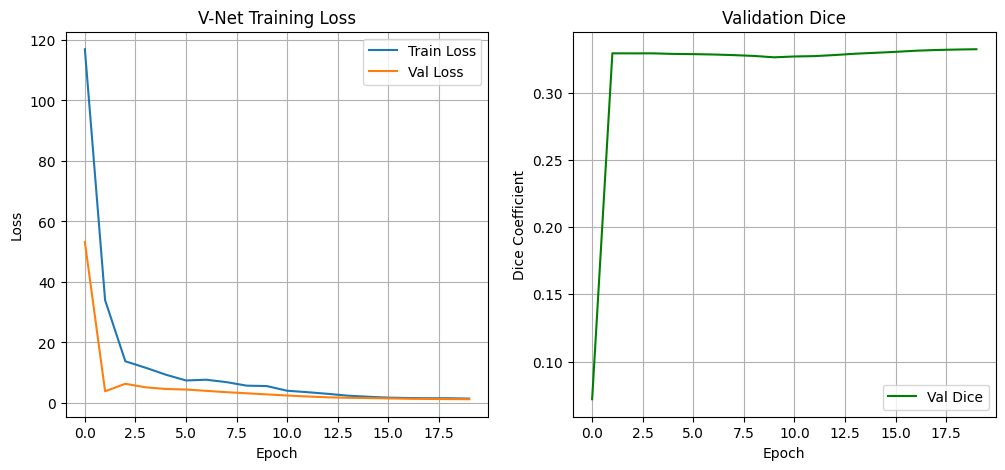

In [46]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('V-Net Training Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history['val_dice'], label='Val Dice', color='green')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Validation Dice')
plt.legend()
plt.grid(True)
plt.show()

11: Final Evaluation

In [52]:
# Ensure model is in eval mode so it outputs a single tensor
model_vnet.eval()

# Use the existing evaluate_model function (works because model.eval() handles the return type)
mean_dice, class_dice, metrics = evaluate_model(model_vnet, small_test_loader, device, num_classes=3)

print(f"Overall mean Dice: {mean_dice:.4f}")
for i, d in enumerate(class_dice):
    print(f"Class {i} Dice: {d:.4f}")

class_names = ["Background", "Vertebrae", "Intervertebral Discs"]
print_metrics(metrics, class_names)

Overall mean Dice: 0.3314
Class 0 Dice: 0.9709
Class 1 Dice: 0.0207
Class 2 Dice: 0.0026

===== Evaluation Metrics per Class =====

               Class  Accuracy  Precision  Recall  F1 Score
          Background    0.9436     0.9785  0.9635    0.9709
           Vertebrae    0.9538     0.0166  0.0281    0.0207
Intervertebral Discs    0.9895     0.0021  0.0038    0.0026




12: Save and Cleanup

In [53]:
# Save weights
torch.save(model_vnet.state_dict(), "/Users/mostafazamaniturk/Documents/USD/AAI-521/AAI-521-finalproject/aai-521-final-project/weights/vnet_deepsup_v1.pth")
print("Model saved.")

# Cleanup
del model_vnet
torch.cuda.empty_cache()
import gc
gc.collect()

Model saved.


29503